In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import os
import glob
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import imageio

import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt

In [2]:
# Data preparation Hyperparameters
NUM_CLASSES = 8
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 10
HEIGHT = 368    # in the current implementation height and width both need to be divisable by 16
WIDTH  = 368

In [3]:
# Randomly splits a Dataset into train and test
# !!! Not used in the final version
def train_test_split(data, ratio):
    train_len = int(len(data)*ratio)
    test_len  = len(data) - train_len
    return random_split(data, [train_len, test_len])

In [4]:
# Create a custom Dataset class

class tensorDataset(Dataset):
    '''
    Inputs:
    - images: list of strings that specify paths to specific tensors
    e.g: '/Users/jedrzejalchimowicz/Desktop/DSBA - Y2S1/Deep_learning/DL_kaggle/data/train_images_96/img96_0.pt'
    - masks: same as images but for masks
    '''
    
    def __init__(self, images:list, masks:list, train:bool, path_img=None, path_msk=None):
        self.image_links = images
        self.mask_links  = masks
        self.train = train
        self.path_img = path_img
        self.path_msk = path_msk
        

    def __getitem__(self, index):
        
        # Select a specific image's link
        img_id  = self.image_links[index]
        mask_id = self.mask_links[index]

        # Load the image (as tensor)
        img  = torch.load(f'{self.path_img}/{img_id}')
        mask = torch.load(f'{self.path_msk}/{mask_id}')
        #mask = torch.sub(mask, 1)
        
        # Apply transformations
        if self.train == True:
          img, mask = self.transform(img, mask)
        
        # Squeeze mask from (1, H, W) to (H, W) -> This is because loss function accepts (B, H, W)
        mask = mask.squeeze(0)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        mask = mask.long()
        
        return img, mask

    
    def __len__(self):
        return len(self.image_links)
    
    
    def transform(self, img, mask):
        
        # Some images in the test set are much brighter/darker than others
        temp_rand = np.random.rand()
        if temp_rand < 0.3:
            t_darken_image = T.ColorJitter(brightness=[0.6, 0.8])
            img = t_darken_image(img)
            # Do nothing for mask - the colors don't change
        elif temp_rand > 0.7:
            t_brighten_image = T.ColorJitter(brightness=[1.2, 1.4])
            img = t_brighten_image(img)
            # Do nothing for mask - the colors don't change
        
        # Flipping images makes sense for satelite images
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)
            mask = t_horizonal_flip(mask)
            
        if np.random.rand() < 0.3:
            t_vertical_flip = T.RandomVerticalFlip(p=1)
            img  = t_vertical_flip(img)
            mask = t_vertical_flip(mask)

        # Add rotations
        if np.random.rand() < 0.3:
          t_rotation = T.RandomRotation(degrees=(0, 180))
          img = t_rotation(img)
          mask = t_rotation(mask)


        return img, mask


In [5]:
# Specify paths to your files (glob glob stores paths to all files in a folder in a list)
import os
train_img_link_list  = sorted(os.listdir('data/new_train_images_368'))
train_mask_link_list = sorted(os.listdir('data/new_train_masks_368'))
val_img_link_list    = sorted(os.listdir('data/new_val_images_368'))
val_mask_link_list   = sorted(os.listdir('data/new_val_masks_368'))

train_dataset = tensorDataset(train_img_link_list, train_mask_link_list, train=True, path_img = 'data/new_train_images_368', path_msk = 'data/new_train_masks_368')
val_dataset   = tensorDataset(val_img_link_list, val_mask_link_list, train=False, path_img = 'data/new_val_images_368', path_msk = 'data/new_val_masks_368')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, shuffle=False)

In [6]:

# Test dataloaders
start = time.time()
for i, batch in enumerate(train_dataloader):
    img_batch, img_mask = batch
    print(img_batch.shape)
    print(img_mask.shape)

for i, batch in enumerate(val_dataloader):
    img_batch, img_mask = batch
    print(img_batch.shape)
    print(img_mask.shape)
      
end = time.time()
print(end - start)

torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
t

torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
t

torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
torch.Size([10, 368, 368])
torch.Size([10, 3, 368, 368])
t

In [6]:
# U-net is composed of several blocks with pooling in between. Each block consists of 2 convolutions,
# therefore to not repeat code at each block we define a class that summarizes it
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            )
    
    def forward(self, x):
        return self.conv(x)

In [7]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES, features=[16, 32, 64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.downs      = nn.ModuleList()
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.ups        = nn.ModuleList()
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.pool       = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        # Down part of U-net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
            
        # Up part of U-net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            # self.ups.append(nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True))
            self.ups.append(DoubleConv(feature*2, feature))
            
    def forward(self, x):
        skip_connections = []
        
        # Go down the Unet
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Go through the bottleneck
        x = self.bottleneck(x)
        # Reverse the skip connections list -> first are going to be used the ones added last
        skip_connections = skip_connections[::-1]
        
        # Go up the Unet
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            
#             #If original input shape not divisable by 16
#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

            skip_connection = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](skip_connection)
        
        # Last convolution that changes channel output size
        x = self.final_conv(x)
        return x

In [8]:
import segmentation_models_pytorch as smp

In [9]:
# Define a function to calculate the Dice score
def f1_dice_score(preds, true_mask):
    '''
    https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
    preds should be (B, 25, H, W)
    true_mask should be (B, H, W)
    '''

    f1_batch = []

    for i in range(len(preds)):
        f1_image = []
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img = torch.argmax(img, dim=0)
    
        for label in range(NUM_CLASSES):
            if torch.sum(mask == label) != 0:
                area_of_intersect = torch.sum((img == label) * (mask == label))
                area_of_img       = torch.sum(img == label)
                area_of_label     = torch.sum(mask == label)
                f1 = 2*area_of_intersect / (area_of_img + area_of_label)
                f1_image.append(f1)
        
        f1_batch.append(np.mean([tensor.cpu() for tensor in f1_image]))
    return np.mean(f1_batch)

# Accuracy
def accuracy(preds, true_mask):
    '''
    preds should be (B, 25, H, W)
    true_mask should be (B, H, W)
    '''
    accuracy_batch = []

    for i in range(len(preds)):
        img  = preds[i].to(DEVICE)
        mask = true_mask[i].to(DEVICE)
        
        # Change shape of img from [25, H, W] to [H, W]
        img  = torch.argmax(img, dim=0)
        
        accuracy_batch.append(torch.sum(img == mask).item() / (HEIGHT*WIDTH))  # FIX LATER
        
    return np.mean(accuracy_batch)

In [10]:
def train():

  min_val_f1 = 0.3

  for epoch in range(STARTING_EPOCH+1, STARTING_EPOCH+EPOCHS+1):
      
      # Train model
      model.train()
      train_losses   = []
      train_accuracy = []
      train_f1       = []
      
      for i, batch in enumerate(train_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch   #img [B,3,H,W], mask[B,H,W]
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Train model
          optimizer.zero_grad()
          # with torch.cuda.amp.autocast():
          output = model(img_batch) # output: [B, 25, H, W]
          loss   = criterion(output, mask_batch)
          loss.backward()

          # torch.nn.utils.clip_grad_norm_(model.parameters(), 6)
          optimizer.step()

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          train_losses.append(loss.item())
          train_accuracy.append(acc)
          train_f1.append(f1)
          # print(f'Train Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')
      
      # Update global metrics
      print(f'TRAIN       Epoch: {epoch} | Epoch metrics | loss: {np.mean(train_losses):.4f}, f1: {np.mean(train_f1):.3f}, accuracy: {np.mean(train_accuracy):.3f}')        
      total_train_losses.append(np.mean(train_losses))
      total_train_accuracy.append(np.mean(train_accuracy))
      total_train_f1.append(np.mean(train_f1))
      
      
      # Validate model
      model.eval()
      val_losses   = []
      val_accuracy = []
      val_f1       = []
      
      for i, batch in enumerate(val_dataloader):
          #Extract data, labels
          img_batch, mask_batch = batch
          img_batch = img_batch.to(DEVICE)
          mask_batch = mask_batch.to(DEVICE)

          #Validate model
          with torch.cuda.amp.autocast():
            output = model(img_batch)
            loss   = criterion(output, mask_batch)

          #Add current loss to temporary list (after 1 epoch take avg of all batch losses)
          f1 = f1_dice_score(output, mask_batch)
          acc = accuracy(output, mask_batch)
          val_losses.append(loss.item())
          val_accuracy.append(acc)
          val_f1.append(f1)
          # print(f'Val Epoch: {epoch}, batch: {i} | Batch metrics | loss: {loss.item():.4f}, f1: {f1:.3f}, accuracy: {acc:.3f}')
      
      # Update global metrics
      print(f'VALIDATION  Epoch: {epoch} | Epoch metrics | loss: {np.mean(val_losses):.4f}, f1: {np.mean(val_f1):.3f}, accuracy: {np.mean(val_accuracy):.3f}')
      print('---------------------------------------------------------------------------------')
      total_val_losses.append(np.mean(val_losses))
      total_val_accuracy.append(np.mean(val_accuracy))
      total_val_f1.append(np.mean(val_f1))
      
      
      # Save the model
      if np.mean(val_f1) > min_val_f1:
        torch.save(model.state_dict(), f'models/PSPNet_res101_368_{epoch}.pt')
        min_val_f1 = np.mean(val_f1)
      
      # Save the results so far
      temp_df = pd.DataFrame(list(zip(total_train_losses, total_val_losses, total_train_f1, total_val_f1,
                                    total_train_accuracy, total_val_accuracy)),
                            columns = ['train_loss', 'val_loss', 'train_f1', 'test_f1', 'train_accuracy',
                                      'test_accuracy'])
      temp_df.to_csv('train_val_measures')

In [14]:
# Initialization
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"

################### UNET ###################
# model = UNET(in_channels=3, out_channels=25).to(DEVICE)
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/FDL_kaggle_data/models/modelBIG_52.pt'))


############### DeepLabV3Plus ##############
# create segmentation model without pretrained encoder- DeepLabV3Plus
model = smp.DeepLabV3Plus(
     encoder_name = 'resnet101', 
     encoder_weights = 'imagenet', 
     classes = 8, 
     activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
 ).to(DEVICE)
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/FDL_kaggle_data/models/DeepLabV3Plus_80.pt'))

################## PSPNet ##################
#Creating a segmentation model with PSPNet
#model = smp.PSPNet(
#    encoder_name = 'resnet101', 
#    encoder_weights = 'imagenet', 
 #   classes = NUM_CLASSES, 
 #   activation = None, # could be None for logits or 'softmax2d' for multiclass segmentation
#).to(DEVICE)

total_train_losses   = []
total_val_losses     = []
total_train_accuracy = []
total_val_accuracy   = []
total_train_f1       = []
total_val_f1         = []

In [15]:

# HYPERPARAMETERS for training run
STARTING_EPOCH = 30
EPOCHS = 50
LR = 0.000001
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss().to(DEVICE)

train()

TRAIN       Epoch: 1 | Epoch metrics | loss: 2.0895, f1: 0.093, accuracy: 0.170
VALIDATION  Epoch: 1 | Epoch metrics | loss: 2.0554, f1: 0.098, accuracy: 0.192
---------------------------------------------------------------------------------
TRAIN       Epoch: 2 | Epoch metrics | loss: 1.9317, f1: 0.150, accuracy: 0.284
VALIDATION  Epoch: 2 | Epoch metrics | loss: 1.9140, f1: 0.142, accuracy: 0.295
---------------------------------------------------------------------------------
TRAIN       Epoch: 3 | Epoch metrics | loss: 1.7961, f1: 0.191, accuracy: 0.366
VALIDATION  Epoch: 3 | Epoch metrics | loss: 1.8021, f1: 0.178, accuracy: 0.356
---------------------------------------------------------------------------------
TRAIN       Epoch: 4 | Epoch metrics | loss: 1.6935, f1: 0.222, accuracy: 0.427
VALIDATION  Epoch: 4 | Epoch metrics | loss: 1.7366, f1: 0.218, accuracy: 0.411
---------------------------------------------------------------------------------
TRAIN       Epoch: 5 | Epoch met

In [81]:
from torchvision.utils import save_image
model.eval()
list_masks=[]
path_img='data/test_368'
test_list = os.listdir('data/test_368')
for i in test_list:
    img  = torch.load(f'{path_img}/{i}').to(DEVICE)
    img = torch.reshape(img, (1, 3, 368, 368))
    with torch.cuda.amp.autocast():
        output = model(img)
        #print(output.shape)
        out_mask = torch.argmax(output[0], dim=0).cpu().detach().numpy()
        save_image(torch.argmax(output[0], dim=0).cpu().type(torch.float32), f'data/test_mask_png/{i[:-3]}_mask.png')
        list_masks.append(out_mask)



In [116]:
list_masks[11][350]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       1, 1, 1, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1,

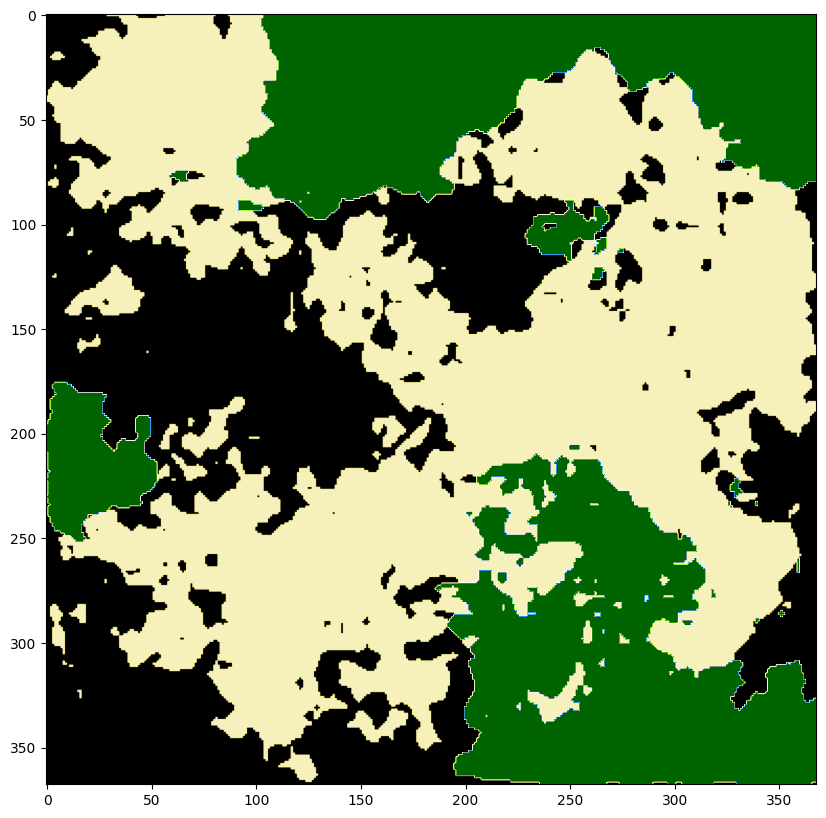

In [117]:
from matplotlib import colors
colors_map = ['black', 'Khaki', 'White', 'Grey', 'DodgerBlue', '#ADFF2F', 'DarkGreen', 'DarkGreen']
classes = ['ignore', 'Building', 'Background', 'Road', 'Water', 'Grace', 'Agricultural' 'Forest']
custom_cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", colors_map)
#f, axarr = plt.subplots(1,1, figsize=(15,15))
for i in range(len(test_list)):
    plt.imshow(list_masks[i], cmap=custom_cmap)
    plt.gcf().set_size_inches(10, 10)
    #axarr[1].imshow(list_masks[3], cmap=custom_cmap)
    plt.savefig(f'data/moscow_masks/{test_list[i][:-3]}.png')
    #plt.show()

In [ ]:
from PIL import Image
import numpy as np
from torchvision.io import read_image

COLOR_MAP = dict(
    IGNORE=(0, 0, 0),
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)


def render(mask_path, vis_path):
    image = torch.load(mask_path)
    image = torchvision.transforms.ToPILImage()(image)
    new_mask = np.array(image).astype(np.uint8)
    cm = np.array(list(COLOR_MAP.values())).astype(np.uint8)
    color_img = cm[new_mask]
    color_img = Image.fromarray(np.uint8(color_img))
    color_img.save(vis_path)

list_mask_test = os.listdir('data/test_mask')

for i in list_mask_test:
    mask_path = f'data/test_mask/{i}'
    vis_path = f'data/test_mask_png/{i[:-3]}.png'
    render(mask_path, vis_path)